In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import Lib.Functions as fc
import Lib.Feature_Selection as ft
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Functions.ipynb
importing Jupyter notebook from /Users/admin/Desktop/User_Acquisition/1. Code/Modelling/Lib/Feature_Selection.ipynb


In [2]:
demographics = pd.read_csv('ICKDemographicsPipeline_v260423.csv')
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173193 entries, 0 to 173192
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   UserID          173193 non-null  object 
 1   TotalChild      173193 non-null  int64  
 2   MedianChildAge  173193 non-null  float64
 3   No.Female       173193 non-null  float64
 4   No.Male         173193 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 6.6+ MB


In [3]:
df_pay = pd.read_csv('RealPaymentsType.csv')
df_pay['UserJoinedDate'] = df_pay['UserJoinedDate'].map(lambda x: x[: 19])
df_pay['UserJoinedDate'] = pd.to_datetime(df_pay['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')
df_pay['JoinMonth'] = df_pay['UserJoinedDate'].dt.month

payment = df_pay[['UserID', 'UserJoinedDate', 'gapday']]
payment.shape

(265308, 3)

In [4]:
detail = pd.read_csv('Engagement_detail_learn_updated.csv')
detail['InteractionLearn'] = detail['UsageTime'] * detail['Records']

detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506702 entries, 0 to 1506701
Data columns (total 8 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   EventDate                  1506702 non-null  object 
 1   nth_day_from_registration  1506702 non-null  int64  
 2   UserID                     1506702 non-null  object 
 3   SubjectName                1506702 non-null  object 
 4   IsCompleted                1506702 non-null  int64  
 5   UsageTime                  1506702 non-null  float64
 6   Records                    1506702 non-null  int64  
 7   InteractionLearn           1506702 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 92.0+ MB


In [5]:
detail = pd.merge(left=detail,
                  right=payment,
                  how='left',
                  on='UserID')
detail.shape

(1506702, 10)

In [6]:
firstday_learn = pd.DataFrame(detail.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday_learn.columns = ['UserID', 'MinFirstDay']

firstday_learn['ZeroDay'] = firstday_learn['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday_learn.shape

(153340, 3)

In [7]:
detail = pd.merge(left=detail,
                  right=firstday_learn,
                  how='left',
                  on='UserID')

detail.loc[detail['gapday'].isnull(), 'gapday'] = 'no_pay'
detail.shape

(1506702, 12)

In [8]:
def DetailBasedNthDay(dataframe, nthday=2):
    pay = dataframe.loc[dataframe['gapday'] != 'no_pay']
    
    mask0 = pay['ZeroDay'] == 'zero'
    mask1 = pay['nth_day_from_registration'] <= nthday
    df0 = pay[mask0 & mask1]
    
    df0['CutoffDay'] = df0['MinFirstDay'] + nthday
    df0['ScaleActionDay'] = df0['nth_day_from_registration'] - 0
    df0['ScaleGapday'] = df0['gapday'] - df0['MinFirstDay']
    
    mask2 = pay['ZeroDay'] != 'zero'
    others = pay[mask2]
    others['CutoffDay'] = others['MinFirstDay'] + nthday
    
    mask3 = others['nth_day_from_registration'] <= others['CutoffDay']
    df1 = others[mask3]
    df1['ScaleActionDay'] = df1['nth_day_from_registration'] - df1['MinFirstDay']
    df1['ScaleGapday'] = df1['gapday'] - df1['MinFirstDay']
    
    purchaser = pd.concat([df0, df1], ignore_index=True)
    
    free = dataframe.loc[dataframe['gapday'] == 'no_pay']
    f0 = free['ZeroDay'] == 'zero'
    f1 = free['nth_day_from_registration'] <= nthday
    free0 = free[f0 & f1]
    
    free0['CutoffDay'] = free0['MinFirstDay'] + nthday
    free0['ScaleActionDay'] = free0['nth_day_from_registration'] - 0
    free0['ScaleGapday'] = free0['gapday']
    
    non0 = free.loc[free['ZeroDay'] != 'zero']
    non0['CutoffDay'] = non0['MinFirstDay'] + nthday
    f3 = non0['nth_day_from_registration'] <= non0['CutoffDay']
    free1 = non0[f3]
    free1['ScaleActionDay'] = free1['nth_day_from_registration'] - free1['MinFirstDay']
    free1['ScaleGapday'] = free1['gapday']
    
    non_purchaser = pd.concat([free0, free1], ignore_index=True)
    
    data = pd.concat([purchaser, non_purchaser], ignore_index=True)
    
    return data

In [9]:
learn_detail = DetailBasedNthDay(detail, nthday=2)

In [10]:
content_learn = learn_detail.pivot_table(index = 'UserID',
                                         columns = 'SubjectName',
                                         values = ['IsCompleted', 'UsageTime', 'Records', 'InteractionLearn'],
                                         aggfunc = np.sum).reset_index()

cols = ['UserID',
        'InteractionEnglish', 'InteractionMath', 'InteractionPhonics', 'InteractionVietnamese',
        'IsCompletedEnglish', 'IsCompletedMath','IsCompletedPhonics', 'IsCompletedVietnamese',
        'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
        'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

content_learn.columns = cols

for col in content_learn.columns[1:]:
    content_learn.loc[content_learn[col].isnull(), col] = 0
    
content_learn.shape

(153340, 17)

In [11]:
engage = pd.read_csv('RealEngagements_updated.csv')
engage['UserJoinedDate'] = engage['UserJoinedDate'].map(lambda x: x[: 19])
engage['UserJoinedDate'] = pd.to_datetime(engage['UserJoinedDate'], format = '%Y-%m-%d %H:%M:%S')

engage['lastuse'] = engage['lastuse'].map(lambda x: x[: 19])
engage['lastuse'] = pd.to_datetime(engage['lastuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse'] = engage['firstuse'].map(lambda x: x[: 19])
engage['firstuse'] = pd.to_datetime(engage['firstuse'], format = '%Y-%m-%d %H:%M:%S')

engage['firstuse_hour'] = engage['firstuse'].dt.hour
engage['lastuse_hour'] = engage['lastuse'].dt.hour
engage['lastuse_day'] = engage['lastuse'].dt.day
engage['lastuse_dayofweek'] = engage['lastuse'].dt.dayofweek
engage['JoinMonth'] = engage['UserJoinedDate'].dt.month

engage.shape

(1638631, 17)

In [12]:
engage = pd.merge(left=engage,
                  right=payment[['UserID', 'gapday']],
                  on='UserID',
                  how='left')
engage.shape

(1638631, 18)

In [13]:
brand = engage['DeviceBrand'].value_counts()

Big = brand[brand >= 100000].index.tolist()
Medium = brand[(brand >= 10000) & (brand < 100000)].index.tolist()
Small = brand[brand < 10000].index.tolist()

def TransformBrand(x):
    if x in Big:
        return 'Big'
    elif x in Medium:
        return 'Medium'
    else:
        return 'Small'

engage['TypeBrand'] = engage['DeviceBrand'].map(lambda x: TransformBrand(x))

engage.loc[engage['gapday'].isnull(), 'gapday'] = 'no_pay'

In [14]:
firstday = pd.DataFrame(engage.groupby(['UserID'])['nth_day_from_registration'].min()).reset_index()
firstday.columns = ['UserID', 'MinFirstDay']

firstday['ZeroDay'] = firstday['MinFirstDay'].map(lambda x: 'zero' if x == 0 else 'other')
firstday.shape

(163040, 3)

In [15]:
engage = pd.merge(left=engage,
                  right=firstday,
                  how='left',
                  on='UserID')
engage.shape

(1638631, 21)

In [16]:
action = DetailBasedNthDay(engage, nthday=2)

In [19]:
action.shape

(393172, 24)

In [20]:
Recency = lambda x: 3 - max(x)

Frequency_content = lambda x: len(x.unique()) # tan suat dang nhap trong 2 ngay
Frequency_payment = lambda x: sum(x)# so lan vao trang thanh toan trong 2 ngay

Monetary_usage = lambda x: sum(x)  # tong thoi gian dung app trong 7 ngay (minutes)
Monetary_record = lambda x: sum(x) # tong so records trong 7 ngay

Mode_firstuse_hour = lambda x: x.mode()[0]
Mode_lastuse_day = lambda x: x.mode()[0]
Mode_lastuse_hour = lambda x: x.mode()[0]
Mode_lastuse_dayofweek = lambda x: x.mode()[0]

active = action.groupby('UserID').agg({'ScaleActionDay': Recency,
                                     'firstuse': Frequency_content,
                                     'payment_screen_time': Frequency_payment,
                                     'UsageTime': Monetary_usage,
                                     'Records': Monetary_record,
                                     'firstuse_hour': Mode_firstuse_hour,
                                     'lastuse_hour': Mode_lastuse_hour,
                                     'lastuse_day': Mode_lastuse_day,
                                     'lastuse_dayofweek': Mode_lastuse_dayofweek}).reset_index()

cols = ['UserID', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 
        'TotalUsageTime','TotalRecords', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay', 'ModeDayofweek']

active.columns = cols

In [21]:
Median_usage = lambda x: x.median()
Median_record = lambda x: x.median()
Median_payment_screentime = lambda x: x.median()

active_median = action.groupby('UserID').agg({'UsageTime': Median_usage,
                                            'Records': Median_record,
                                            'payment_screen_time': Median_payment_screentime}).reset_index()

cols = ['UserID', 'MedianUsageTime', 'MedianRecord', 'MedianPaymentScreen']

active_median.columns = cols

In [22]:
action['Counting'] = [1] * action.shape[0]

brand = action.pivot_table(index = 'UserID',
                             columns = 'TypeBrand',
                             values = ['Counting'],
                             aggfunc = np.sum).reset_index()

brand_cols = ['UserID', 'BigBrand', 'MediumBrand', 'SmallBrand']
        
brand.columns = brand_cols

for col in brand.columns[1:]:
    brand.loc[brand[col].isnull(), col] = 0
    
brand.shape

(163040, 4)

In [23]:
content_sum = action.pivot_table(index = 'UserID',
                                    columns = 'ActionType',
                                    values = ['UsageTime', 'Records'],
                                    aggfunc = np.sum).reset_index()

new_cols = ['UserID',
            'RecordDiscovery', 'RecordEntertainment', 'RecordLearn',
            'UsageTimeDiscovery', 'UsageTimeEntertainment', 'UsageTimeLearn']

content_sum.columns = new_cols

for col in content_sum.columns[1:]:
    content_sum.loc[content_sum[col].isnull(), col] = 0

In [24]:
Number_of_device = lambda x: len(x.unique())

demo = action.groupby('UserID').agg({'TypeBrand': Number_of_device}).reset_index()

demo.columns = ['UserID', 'No.TypeBrand']

demo

,UserID,No.TypeBrand
0,00002520-3fe9-4d4b-9e1f-e4a72386bf47,1
1,00007f9f-be36-4a0d-a2a8-167231588625,1
2,00015787-1ed9-45b9-9c5f-2613e2ca8409,1
3,0001f256-edcf-4980-b84b-85d85745fd0f,1
4,000234a9-a233-4476-9023-9b83f331b7f6,1
...,...,...
163035,fffdf7d4-a6c3-46e6-bbb7-045211d7007f,1
163036,ffff2125-692f-4755-bfcd-59219e49d6d6,1
163037,ffff56de-effe-4b67-9990-33240f51c866,1
163038,ffff81a7-4938-4d26-8492-bd8e4acc2a19,1


In [25]:
print(active.shape)
print(content_sum.shape)
print(active_median.shape)
print(brand.shape)
print(content_learn.shape)
print(demo.shape)
print(demographics.shape)

(163040, 10)
(163040, 7)
(163040, 4)
(163040, 4)
(153340, 17)
(163040, 2)
(173193, 5)


In [26]:
data_list = [active, demographics, demo, brand, content_learn, content_sum, active_median, 
             df_pay[['UserID', 'firstPaymentType', 'JoinMonth','gapday']]]

final = active.copy()

for x in data_list[1:]:
    final = pd.merge(left=final,
                     right=x,
                     how='left',
                     on='UserID')
final.shape

(163040, 46)

In [27]:
null_idx = final.loc[final['TotalChild'].isnull()].index.tolist()

final = final.drop(null_idx)
final.shape

(158981, 46)

In [235]:
data = final.copy()

In [236]:
learning_detail = ['InteractionEnglish', 'InteractionMath','InteractionPhonics', 'InteractionVietnamese', 
                   'IsCompletedEnglish', 'IsCompletedMath', 'IsCompletedPhonics', 'IsCompletedVietnamese',
                   'RecordEnglish', 'RecordMath', 'RecordPhonics', 'RecordVietnamese',
                   'UsageTimeEnglish', 'UsageTimeMath', 'UsageTimePhonics', 'UsageTimeVietnamese']

for col in learning_detail:
    data.loc[data[col].isnull(), col] = 0

In [237]:
data['AvgTimePerCompletion'] = data['TotalUsageTime'] / data['TotalRecords']
data['InteractionGeneral'] = data['TotalUsageTime'] * data['TotalRecords']
data['InteractionLearn'] = data['UsageTimeLearn'] * data['RecordLearn']
data['InteractionDiscovery'] = data['UsageTimeDiscovery'] * data['RecordDiscovery']
data['InteractionEntertainment'] = data['UsageTimeEntertainment'] * data['RecordEntertainment']
data['MedianInteraction'] = data['MedianUsageTime'] * data['MedianRecord']

In [238]:
data['Label'] = data['gapday'].map(lambda x: 1 if x <= 31 else 0)

In [239]:
data['Label'].value_counts()

0    148681
1     10300
Name: Label, dtype: int64

In [240]:
data1 = data.copy()

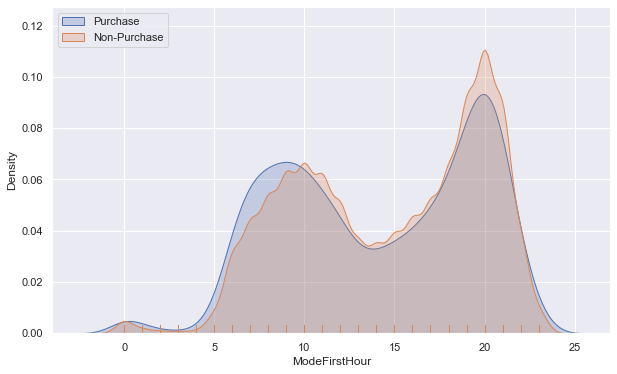

In [34]:
plt.figure(figsize=(10, 6))
sb.distplot(data.loc[data['Label'] == 1]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Purchase')
sb.distplot(data.loc[data['Label'] == 0]['ModeFirstHour'], kde_kws={'shade':'kde_kws'},
                                                             hist = False, rug = True,label='Non-Purchase')
plt.legend(loc='upper left');

In [241]:
excludes = ['firstPaymentType', 'Recency', 'ContentFrequent', 'PaymentScreenFrequent', 'TotalChild', 
            'MedianChildAge', 'No.Female', 'No.Male', 'No.TypeBrand', 'BigBrand', 'MediumBrand',
            'SmallBrand', 'Label', 'gapday', 'JoinMonth', 'ModeFirstHour', 'ModeLastHour', 'ModeLastDay',
            'ModeDayofweek']

for col in data.columns[1:]:
    if col not in excludes:
        if data[col].min() == 0:
            data[col] = data[col] + 1
            data[col] = np.log(data[col])
        else:
            data[col] = np.log(data[col])

In [242]:
data.to_csv('ICK_Active2thdays.csv', index=False)

----- TotalUsageTime -----
count    158981.000000
mean          2.558697
std           1.241461
min           0.000000
25%           1.572774
50%           2.636912
75%           3.494991
max           7.235648
Name: TotalUsageTime, dtype: float64
* Variance: 1.5412261419140934
* Median: 2.6369121732688705
* Skewness: -0.02154754166234907
* Kurtosis: -0.8015501095631112
* Percentage of outliers: 6.919065800315761e-05
* Number of missing value: 0


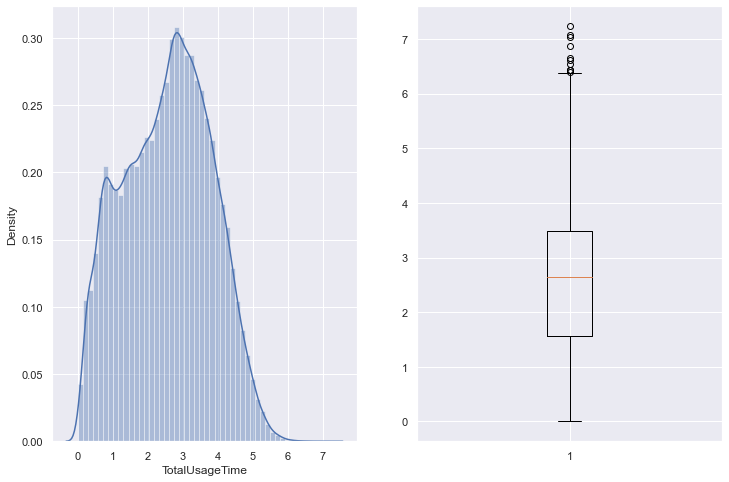


----- TotalRecords -----
count    158981.000000
mean          2.454254
std           1.282153
min           0.000000
25%           1.609438
50%           2.564949
75%           3.401197
max           6.496775
Name: TotalRecords, dtype: float64
* Variance: 1.6439159085833983
* Median: 2.5649493574615367
* Skewness: -0.22781687890509367
* Kurtosis: -0.67996081954281
* Percentage of outliers: 6.919065800315761e-05
* Number of missing value: 0


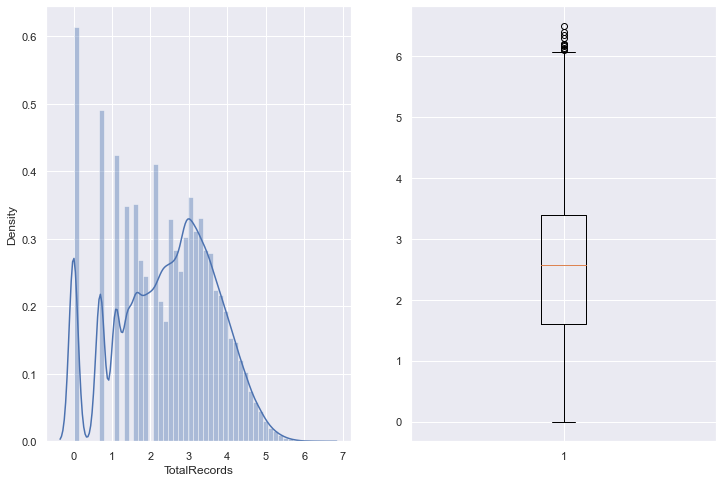


----- InteractionEnglish -----
count    158981.000000
mean          2.030741
std           2.410985
min           0.000000
25%           0.000000
50%           0.667829
75%           4.251776
max          12.111184
Name: InteractionEnglish, dtype: float64
* Variance: 5.812846828187239
* Median: 0.6678293725756554
* Skewness: 0.7580006367582864
* Kurtosis: -0.8544937049504187
* Percentage of outliers: 6.290059818468874e-05
* Number of missing value: 0


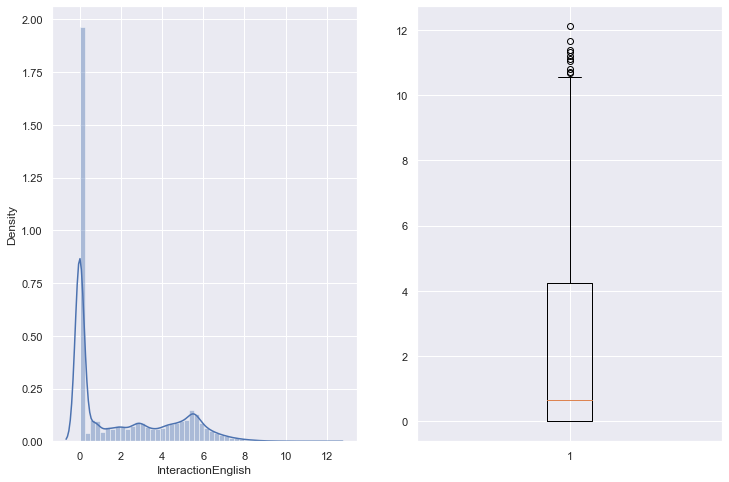


----- InteractionMath -----
count    158981.000000
mean          0.073066
std           0.574088
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.701298
Name: InteractionMath, dtype: float64
* Variance: 0.3295765064464487
* Median: 0.0
* Skewness: 9.285574535267058
* Kurtosis: 93.62335189876812
* Percentage of outliers: 0.025606833520986784
* Number of missing value: 0


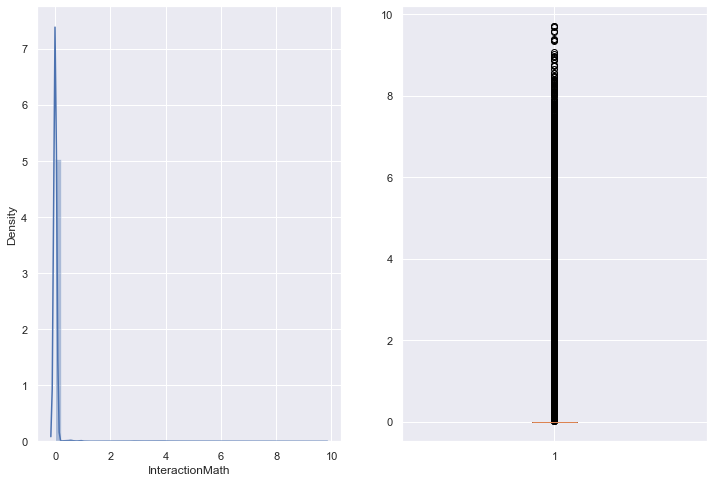


----- InteractionPhonics -----
count    158981.000000
mean          0.081541
std           0.577795
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           9.136632
Name: InteractionPhonics, dtype: float64
* Variance: 0.33384749292014415
* Median: 0.0
* Skewness: 8.321851324466543
* Kurtosis: 75.14940632993383
* Percentage of outliers: 0.02804108667073424
* Number of missing value: 0


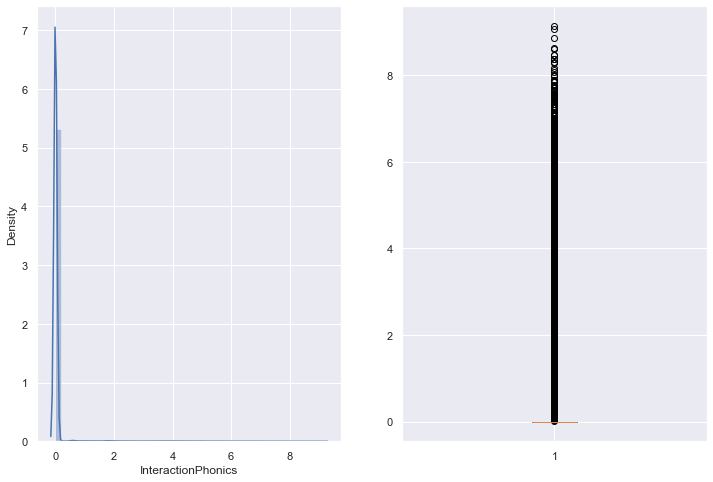


----- InteractionVietnamese -----
count    158981.000000
mean          2.161028
std           2.556175
min           0.000000
25%           0.000000
50%           0.741937
75%           4.315753
max          11.584475
Name: InteractionVietnamese, dtype: float64
* Variance: 6.534032482588937
* Median: 0.7419373447293773
* Skewness: 0.8136744579351566
* Kurtosis: -0.7088246861189402
* Percentage of outliers: 6.290059818468874e-05
* Number of missing value: 0


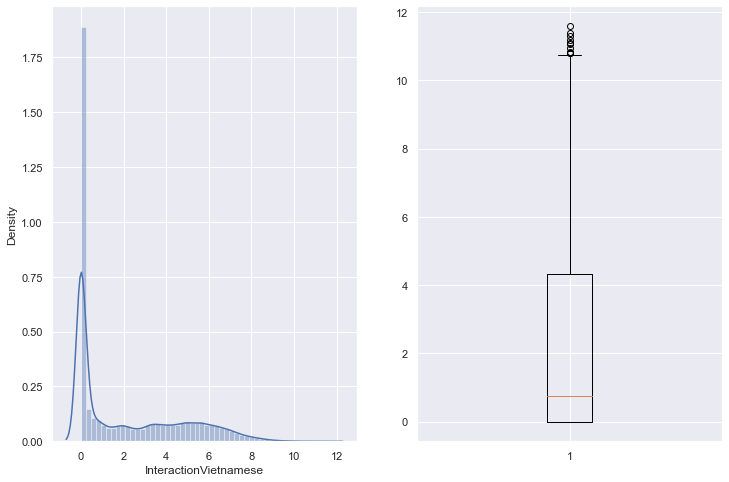


----- IsCompletedEnglish -----
count    158981.000000
mean          0.433578
std           0.453233
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.386294
Name: IsCompletedEnglish, dtype: float64
* Variance: 0.2054202161132386
* Median: 0.6931471805599453
* Skewness: 0.4007335863409
* Kurtosis: -1.1997710088924718
* Percentage of outliers: 0.0
* Number of missing value: 0


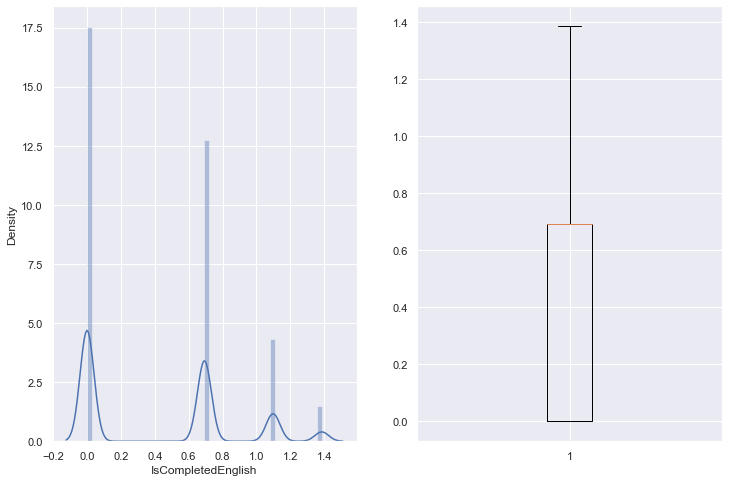


----- IsCompletedMath -----
count    158981.000000
mean          0.018798
std           0.125371
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.386294
Name: IsCompletedMath, dtype: float64
* Variance: 0.015717882180801473
* Median: 0.0
* Skewness: 7.055254401481297
* Kurtosis: 52.170914492796356
* Percentage of outliers: 0.023424182763978084
* Number of missing value: 0


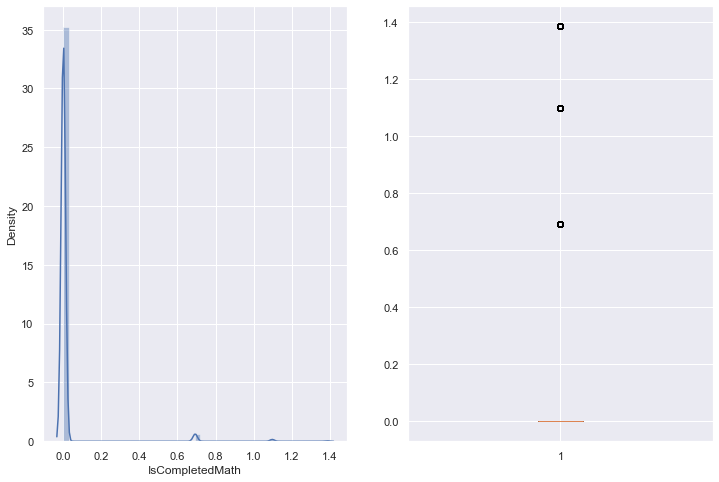


----- IsCompletedPhonics -----
count    158981.000000
mean          0.020142
std           0.128175
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.386294
Name: IsCompletedPhonics, dtype: float64
* Variance: 0.016428954499717208
* Median: 0.0
* Skewness: 6.688089470668544
* Kurtosis: 46.61980099840284
* Percentage of outliers: 0.02553135280316516
* Number of missing value: 0


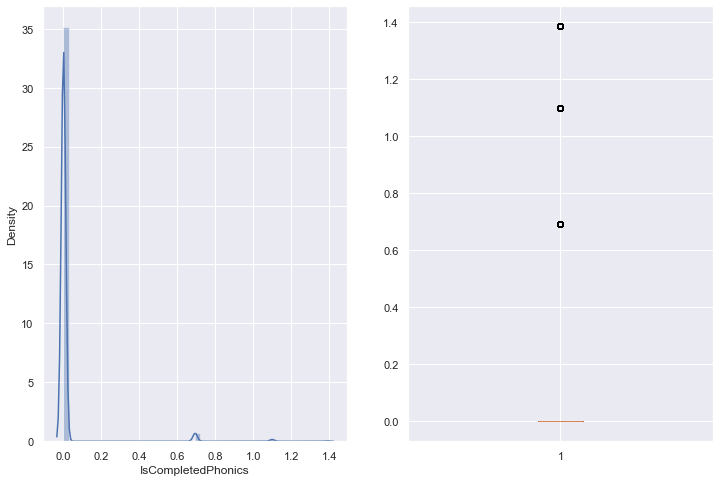


----- IsCompletedVietnamese -----
count    158981.000000
mean          0.449995
std           0.461316
min           0.000000
25%           0.000000
50%           0.693147
75%           0.693147
max           1.386294
Name: IsCompletedVietnamese, dtype: float64
* Variance: 0.2128127788945344
* Median: 0.6931471805599453
* Skewness: 0.3802768215918729
* Kurtosis: -1.1958741430887887
* Percentage of outliers: 0.0
* Number of missing value: 0


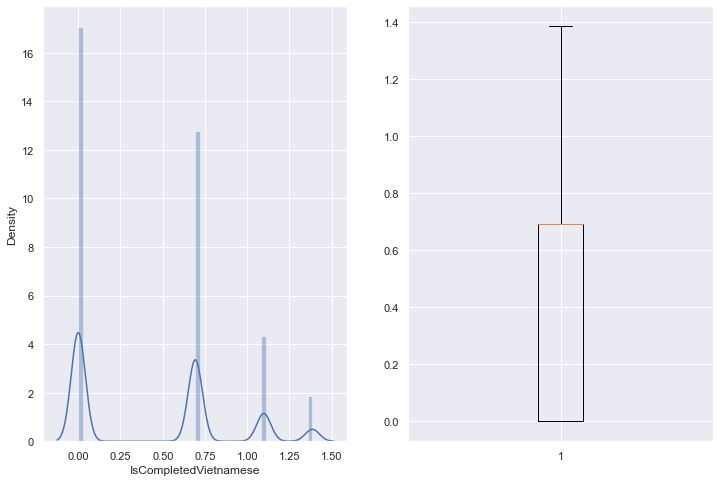


----- RecordEnglish -----
count    158981.000000
mean          1.264774
std           1.391200
min           0.000000
25%           0.000000
50%           0.693147
75%           2.564949
max           6.182085
Name: RecordEnglish, dtype: float64
* Variance: 1.9354377327303451
* Median: 0.6931471805599453
* Skewness: 0.5798159742404951
* Kurtosis: -1.0652204579115099
* Percentage of outliers: 0.0
* Number of missing value: 0


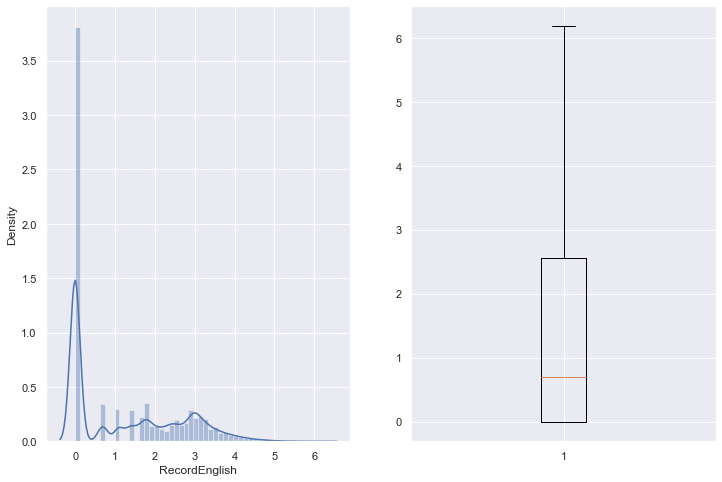


----- RecordMath -----
count    158981.000000
mean          0.048325
std           0.335092
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.164786
Name: RecordMath, dtype: float64
* Variance: 0.11228676918712154
* Median: 0.0
* Skewness: 7.999772799391559
* Kurtosis: 69.50952637183029
* Percentage of outliers: 0.02562570370044219
* Number of missing value: 0


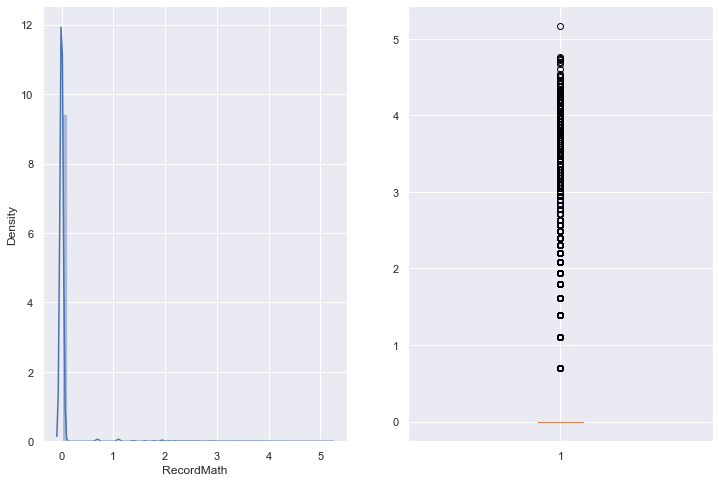


----- RecordPhonics -----
count    158981.000000
mean          0.051998
std           0.339943
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.318120
Name: RecordPhonics, dtype: float64
* Variance: 0.11556098925077052
* Median: 0.0
* Skewness: 7.470342041971583
* Kurtosis: 60.45834379257292
* Percentage of outliers: 0.028072536969826582
* Number of missing value: 0


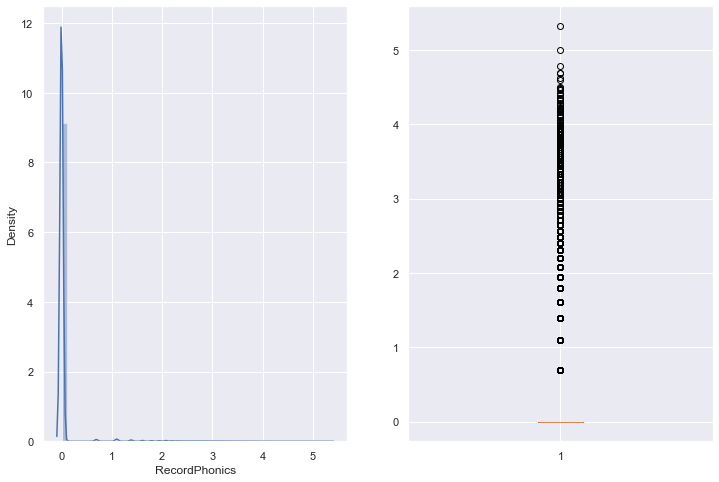


----- RecordVietnamese -----
count    158981.000000
mean          1.301642
std           1.402764
min           0.000000
25%           0.000000
50%           0.693147
75%           2.484907
max           6.345636
Name: RecordVietnamese, dtype: float64
* Variance: 1.9677456466401273
* Median: 0.6931471805599453
* Skewness: 0.6751700337614968
* Kurtosis: -0.7997103771215941
* Percentage of outliers: 1.887017945540662e-05
* Number of missing value: 0


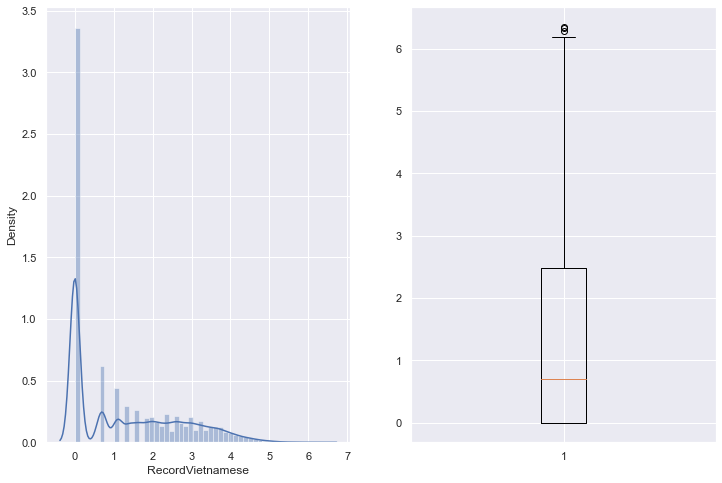


----- UsageTimeEnglish -----
count    158981.000000
mean          1.114511
std           1.277063
min           0.000000
25%           0.000000
50%           0.641854
75%           2.234306
max           7.196971
Name: UsageTimeEnglish, dtype: float64
* Variance: 1.6308895588166952
* Median: 0.6418538861723947
* Skewness: 0.7328666973876179
* Kurtosis: -0.7427927190029737
* Percentage of outliers: 0.00020128191419100394
* Number of missing value: 0


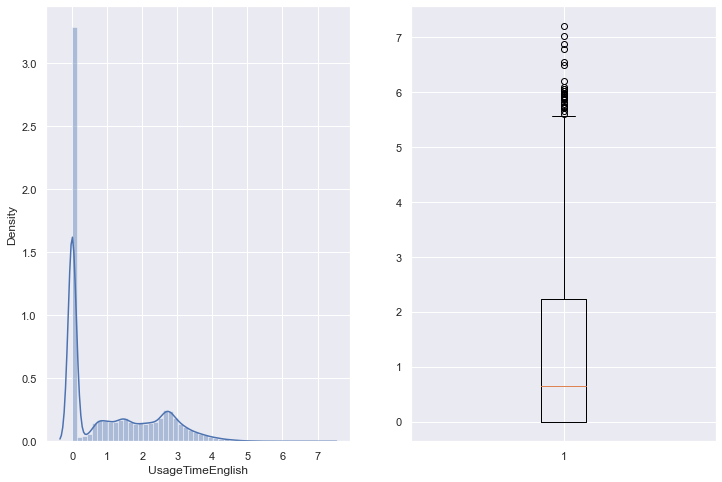


----- UsageTimeMath -----
count    158981.000000
mean          0.042239
std           0.321247
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.889902
Name: UsageTimeMath, dtype: float64
* Variance: 0.10319937466173482
* Median: 0.0
* Skewness: 9.16893095403368
* Kurtosis: 92.77674912936507
* Percentage of outliers: 0.025606833520986784
* Number of missing value: 0


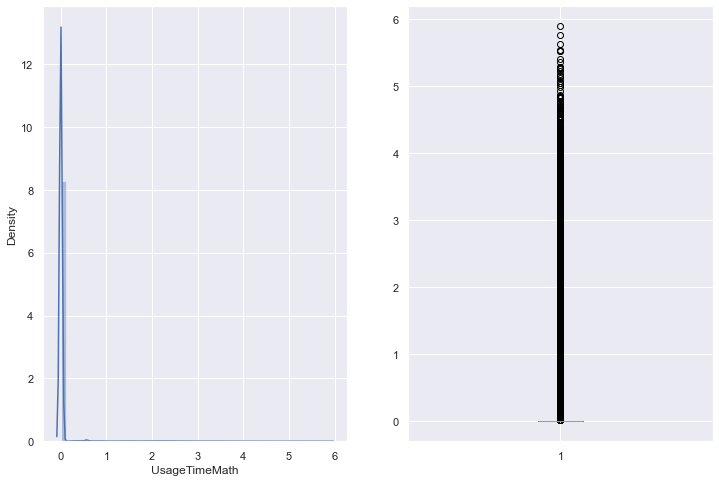


----- UsageTimePhonics -----
count    158981.000000
mean          0.049834
std           0.333300
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.143475
Name: UsageTimePhonics, dtype: float64
* Variance: 0.1110887931743262
* Median: 0.0
* Skewness: 7.673101073742698
* Kurtosis: 63.778896308533085
* Percentage of outliers: 0.02804108667073424
* Number of missing value: 0


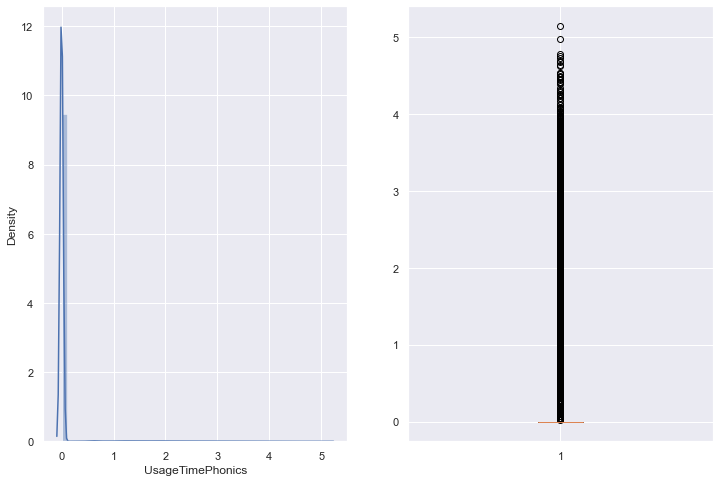


----- UsageTimeVietnamese -----
count    158981.000000
mean          1.222350
std           1.374856
min           0.000000
25%           0.000000
50%           0.652325
75%           2.384165
max           6.448272
Name: UsageTimeVietnamese, dtype: float64
* Variance: 1.8902299993057228
* Median: 0.6523251860396901
* Skewness: 0.7293730043001528
* Kurtosis: -0.7819405657268814
* Percentage of outliers: 3.774035891081324e-05
* Number of missing value: 0


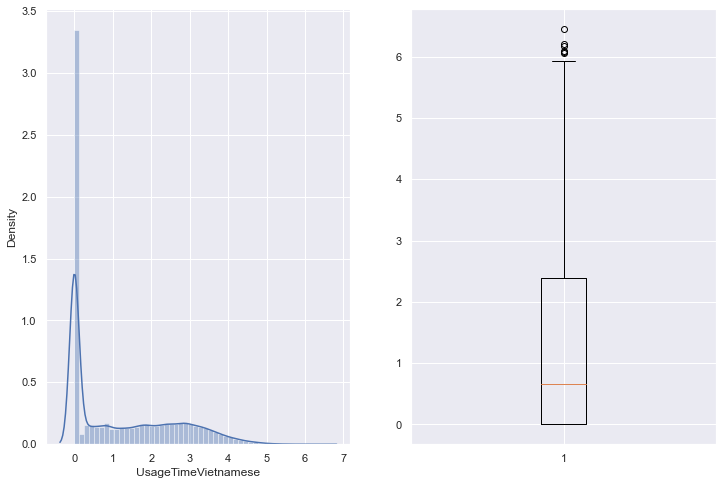


----- RecordDiscovery -----
count    158981.000000
mean          0.561186
std           0.837894
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.170484
Name: RecordDiscovery, dtype: float64
* Variance: 0.7020664878118065
* Median: 0.0
* Skewness: 1.308808955784759
* Kurtosis: 0.5872438734829517
* Percentage of outliers: 0.018127952396827293
* Number of missing value: 0


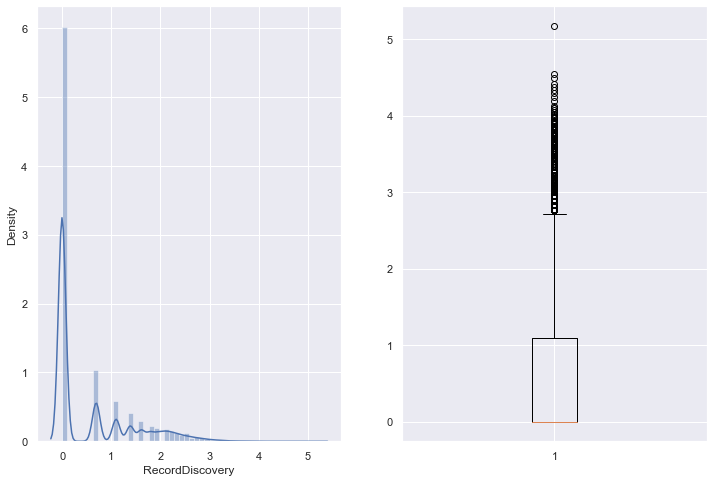


----- RecordEntertainment -----
count    158981.000000
mean          0.661073
std           0.976992
min           0.000000
25%           0.000000
50%           0.000000
75%           1.098612
max           5.905362
Name: RecordEntertainment, dtype: float64
* Variance: 0.9545127717572749
* Median: 0.0
* Skewness: 1.3787100853380034
* Kurtosis: 1.0127554960042322
* Percentage of outliers: 0.049496480711531565
* Number of missing value: 0


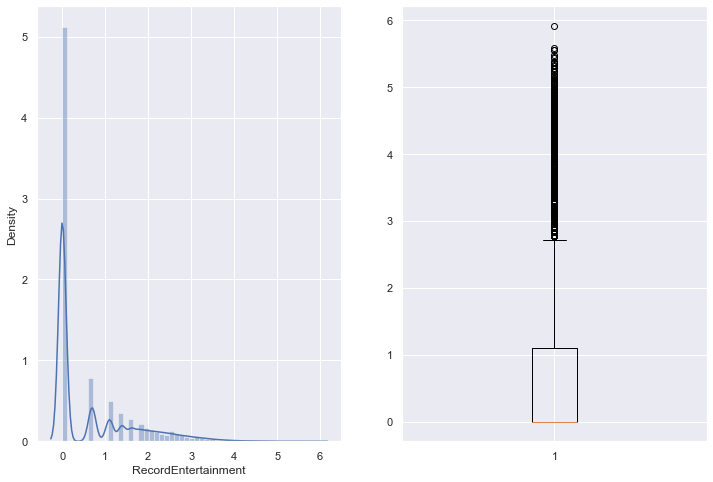


----- RecordLearn -----
count    158981.000000
mean          2.329352
std           1.199687
min           0.000000
25%           1.386294
50%           2.397895
75%           3.218876
max           6.393591
Name: RecordLearn, dtype: float64
* Variance: 1.4392483694514542
* Median: 2.3978952727983707
* Skewness: -0.06652472660321908
* Kurtosis: -0.686224281129237
* Percentage of outliers: 7.548071782162648e-05
* Number of missing value: 0


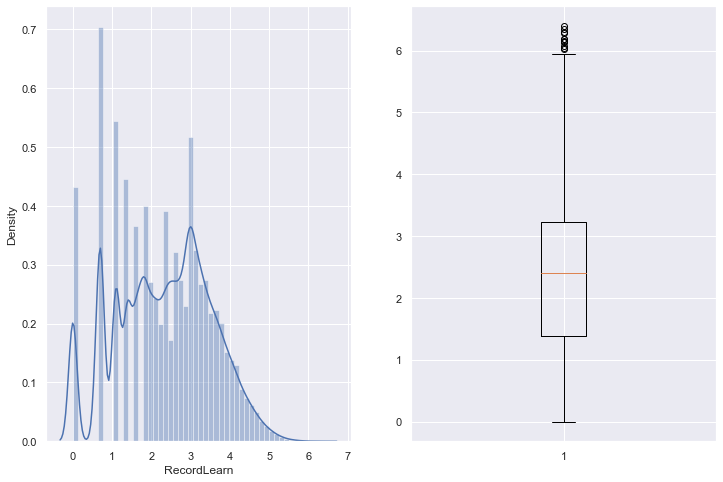


----- UsageTimeDiscovery -----
count    158981.000000
mean          0.736691
std           1.140961
min           0.000000
25%           0.000000
50%           0.000000
75%           1.470176
max           6.022212
Name: UsageTimeDiscovery, dtype: float64
* Variance: 1.3017918085796558
* Median: 0.0
* Skewness: 1.2749615929437557
* Kurtosis: 0.24170761286917086
* Percentage of outliers: 0.01384442166044999
* Number of missing value: 0


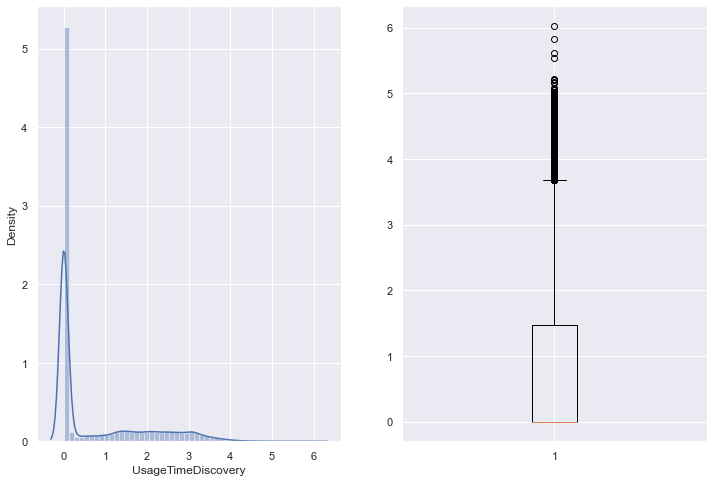


----- UsageTimeEntertainment -----
count    158981.000000
mean          0.737854
std           1.200380
min           0.000000
25%           0.000000
50%           0.000000
75%           1.214913
max           6.394343
Name: UsageTimeEntertainment, dtype: float64
* Variance: 1.440911681781144
* Median: 0.0
* Skewness: 1.5633136993864034
* Kurtosis: 1.3610729980814065
* Percentage of outliers: 0.07877670916650417
* Number of missing value: 0


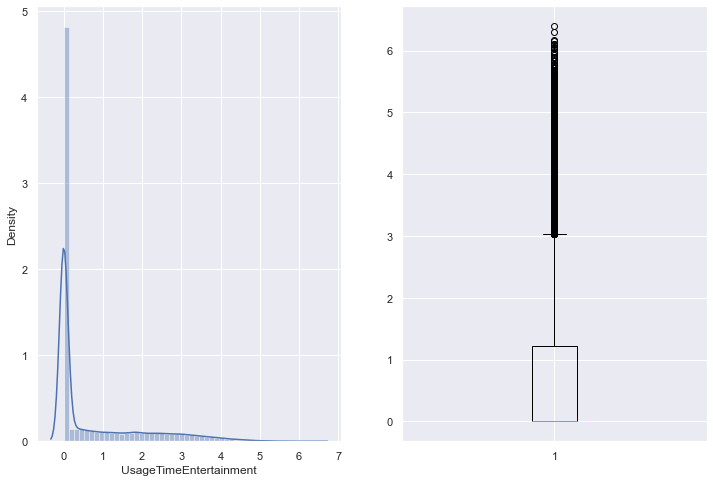


----- UsageTimeLearn -----
count    158981.000000
mean          2.137590
std           1.206770
min           0.000000
25%           1.163151
50%           2.217027
75%           3.026746
max           7.231424
Name: UsageTimeLearn, dtype: float64
* Variance: 1.4562943986152315
* Median: 2.217027204632399
* Skewness: 0.010354827091881739
* Kurtosis: -0.7679477030457598
* Percentage of outliers: 0.00022015209364641057
* Number of missing value: 0


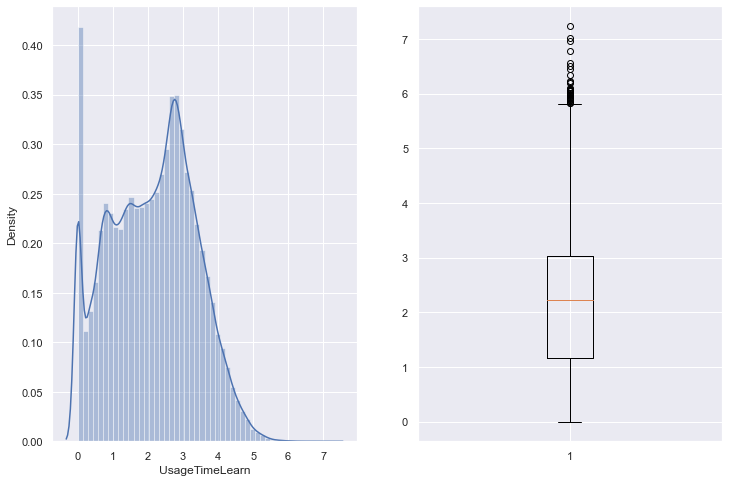


----- MedianUsageTime -----
count    158981.000000
mean          1.860427
std           0.844516
min           0.000000
25%           1.217876
50%           1.898369
75%           2.489065
max           6.095104
Name: MedianUsageTime, dtype: float64
* Variance: 0.7132080872055259
* Median: 1.8983692042863132
* Skewness: -0.001741318664501157
* Kurtosis: -0.6057039015194396
* Percentage of outliers: 0.0008177077764009536
* Number of missing value: 0


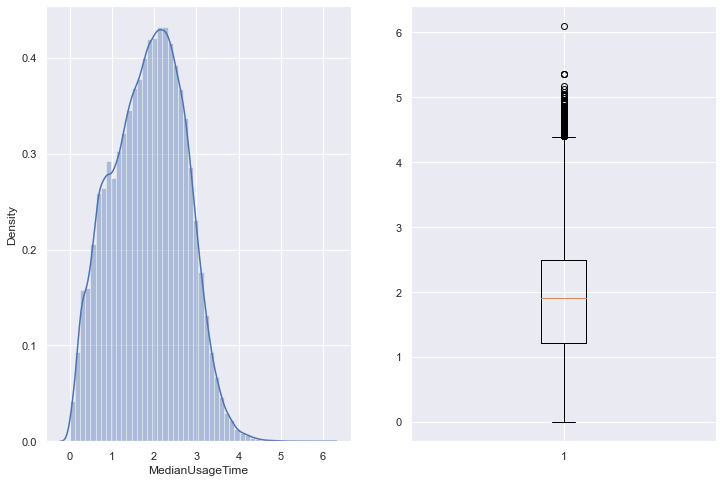


----- MedianRecord -----
count    158981.000000
mean          1.640642
std           0.946951
min           0.000000
25%           1.098612
50%           1.609438
75%           2.302585
max           5.231109
Name: MedianRecord, dtype: float64
* Variance: 0.8967165533117948
* Median: 1.6094379124341003
* Skewness: -0.01943608920988808
* Kurtosis: -0.624405617295611
* Percentage of outliers: 0.002044269441002384
* Number of missing value: 0


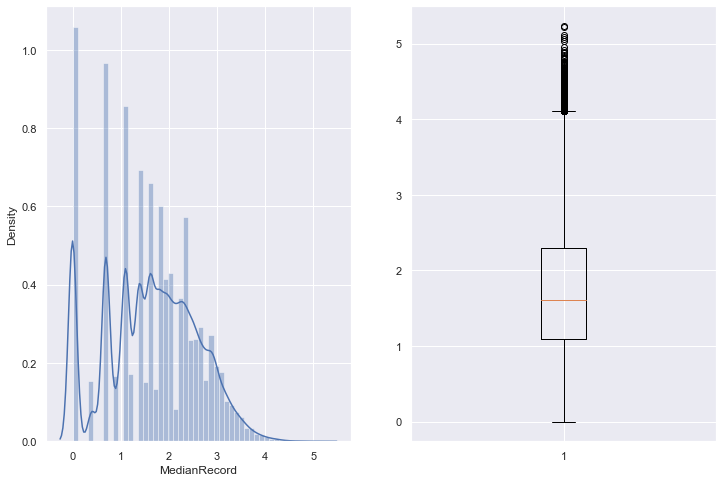


----- MedianPaymentScreen -----
count    158981.000000
mean          0.472506
std           0.679076
min           0.000000
25%           0.000000
50%           0.000000
75%           0.693147
max           5.209486
Name: MedianPaymentScreen, dtype: float64
* Variance: 0.46114450731047524
* Median: 0.0
* Skewness: 1.4256115200069919
* Kurtosis: 1.6005721401113964
* Percentage of outliers: 0.0658380561199137
* Number of missing value: 0


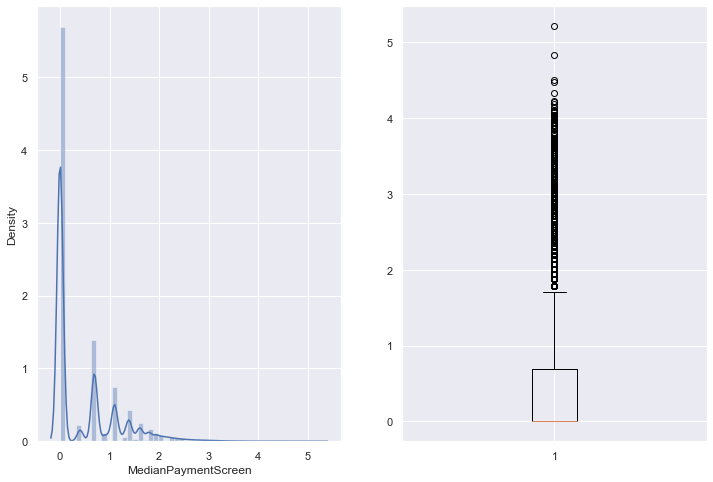


----- AvgTimePerCompletion -----
count    158981.000000
mean          0.674799
std           0.256660
min           0.000000
25%           0.520776
50%           0.631272
75%           0.794896
max           4.224934
Name: AvgTimePerCompletion, dtype: float64
* Variance: 0.06587435219387437
* Median: 0.6312717768418578
* Skewness: 1.1677694674961425
* Kurtosis: 3.6293081599403263
* Percentage of outliers: 0.04391719765254968
* Number of missing value: 0


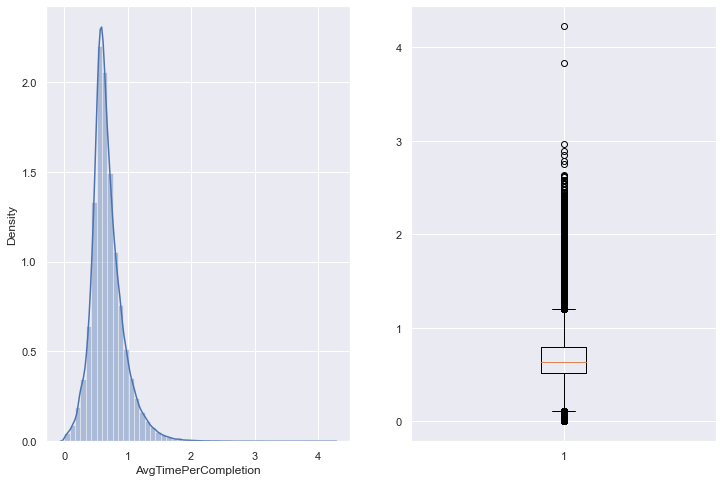


----- InteractionGeneral -----
count    158981.000000
mean          4.924211
std           2.541123
min           0.000000
25%           2.933857
50%           5.172187
75%           6.854987
max          13.410796
Name: InteractionGeneral, dtype: float64
* Variance: 6.457304082993877
* Median: 5.172187089403825
* Skewness: -0.10449238885135169
* Kurtosis: -0.8478138514031728
* Percentage of outliers: 3.145029909234437e-05
* Number of missing value: 0


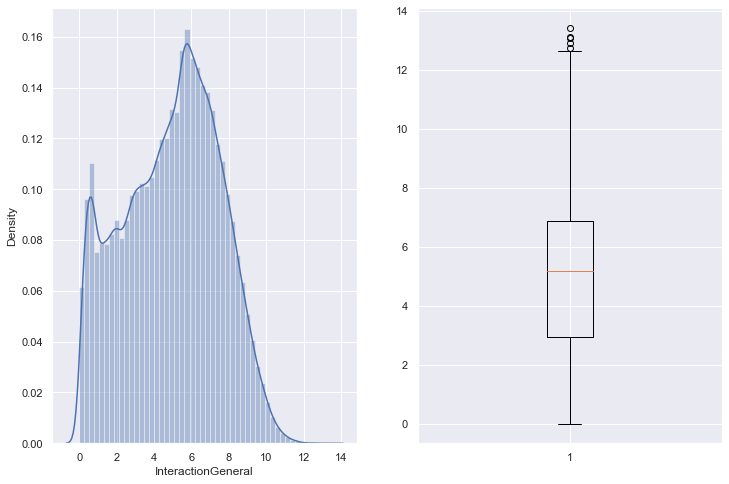


----- InteractionLearn -----
count    158981.000000
mean          4.205053
std           2.555477
min           0.000000
25%           2.043814
50%           4.416428
75%           6.125886
max          13.387681
Name: InteractionLearn, dtype: float64
* Variance: 6.530461953942951
* Median: 4.416428061391214
* Skewness: -0.0018928337449449358
* Kurtosis: -0.9275821210114712
* Percentage of outliers: 5.0320478547750986e-05
* Number of missing value: 0


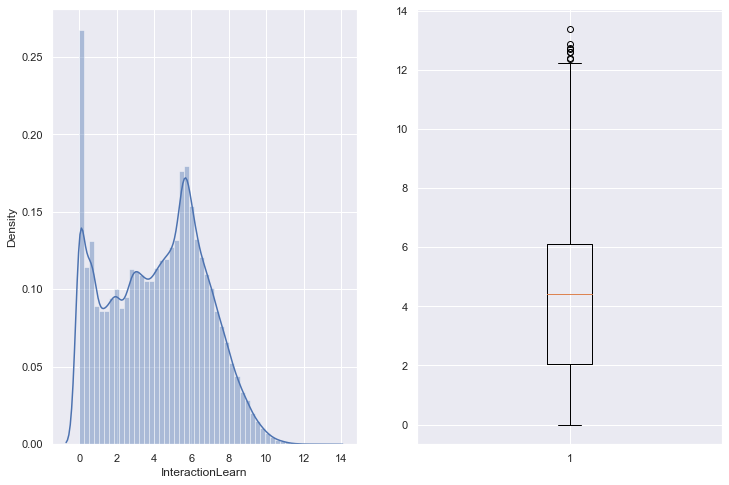


----- InteractionDiscovery -----
count    158981.000000
mean          1.136978
std           1.872696
min           0.000000
25%           0.000000
50%           0.000000
75%           1.808289
max          10.552410
Name: InteractionDiscovery, dtype: float64
* Variance: 3.506990300154582
* Median: 0.0
* Skewness: 1.5119299840468705
* Kurtosis: 1.049812466363147
* Percentage of outliers: 0.09739528622917204
* Number of missing value: 0


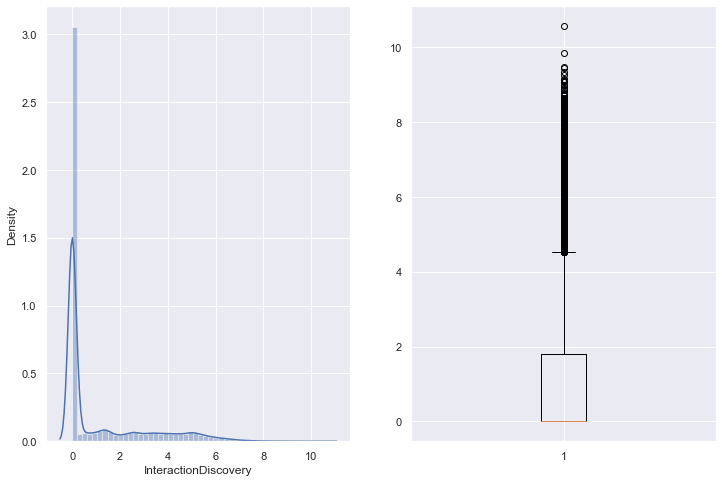


----- InteractionEntertainment -----
count    158981.000000
mean          1.230433
std           2.074853
min           0.000000
25%           0.000000
50%           0.000000
75%           1.868721
max          11.452716
Name: InteractionEntertainment, dtype: float64
* Variance: 4.305014191724737
* Median: 0.0
* Skewness: 1.674561579371541
* Kurtosis: 1.8103477795890668
* Percentage of outliers: 0.10367905598782244
* Number of missing value: 0


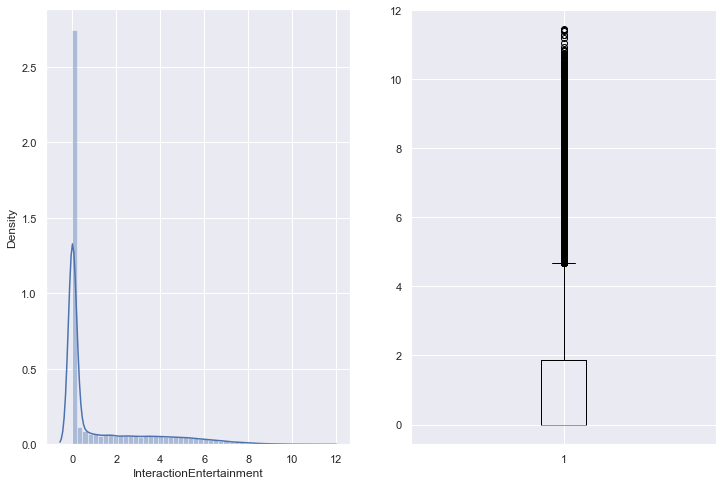


----- MedianInteraction -----
count    158981.000000
mean          3.380542
std           1.758920
min           0.000000
25%           2.008214
50%           3.430513
75%           4.690889
max          10.423610
Name: MedianInteraction, dtype: float64
* Variance: 3.09379949615072
* Median: 3.4305134359962084
* Skewness: 0.056538843761215304
* Kurtosis: -0.7029931290661322
* Percentage of outliers: 0.0005661053836621986
* Number of missing value: 0


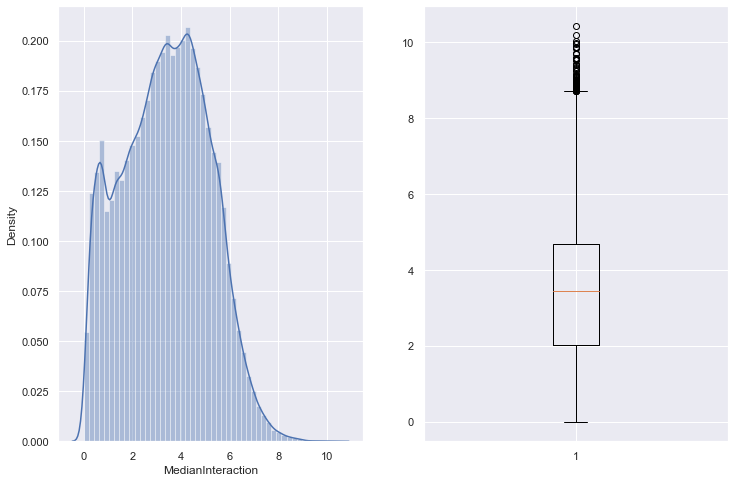

In [36]:
for col in data.columns[1:]:
    if col not in excludes:
        fc.continuous_analysis(data, col)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158981 entries, 0 to 163039
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   UserID                    158981 non-null  object 
 1   Recency                   158981 non-null  int64  
 2   ContentFrequent           158981 non-null  int64  
 3   PaymentScreenFrequent     158981 non-null  int64  
 4   TotalUsageTime            158981 non-null  float64
 5   TotalRecords              158981 non-null  float64
 6   ModeFirstHour             158981 non-null  int64  
 7   ModeLastHour              158981 non-null  int64  
 8   ModeLastDay               158981 non-null  int64  
 9   ModeDayofweek             158981 non-null  int64  
 10  TotalChild                158981 non-null  float64
 11  MedianChildAge            158981 non-null  float64
 12  No.Female                 158981 non-null  float64
 13  No.Male                   158981 non-null  f

In [38]:
X = data.drop(['UserID', 'Label', 'firstPaymentType', 'gapday'], axis = 1)
y = data['Label']

In [39]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [40]:
def ScaleData(train_data, test_data, method=None):
    from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
    if method==None:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'min_max':
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    elif method == 'robust':
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

In [41]:
X_train_norm, X_test_norm = ScaleData(X_train, X_test, method=None)
X_train_mm, X_test_mm = ScaleData(X_train, X_test, method='min_max')
X_train_rb, X_test_rb = ScaleData(X_train, X_test, method='robust')

In [42]:
sw = fc.BinarySampleWeights(X_train.shape[0], y_train)
sw_zen = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'zen')
sw_isns = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'isns')
sw_eff = fc.BinarySampleWeights(X_train.shape[0], y_train, method = 'ens', beta = 0.99999)

In [43]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(random_state = 42)
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.9400946659957228

In [44]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9415

* Confusion Matrix: 
[[29674    63]
 [ 1797   263]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     29737
           1       0.81      0.13      0.22      2060

    accuracy                           0.94     31797
   macro avg       0.87      0.56      0.60     31797
weighted avg       0.93      0.94      0.92     31797



In [45]:
import lightgbm as lgbm

lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 100,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9268225562963894

In [46]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.922

* Confusion Matrix: 
[[28246  1491]
 [  990  1070]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.42      0.52      0.46      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.73      0.71     31797
weighted avg       0.93      0.92      0.93     31797



In [54]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 500,
                               scale_pos_weight=5,
                               metric='auc')

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9571251100767392

In [55]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9296

* Confusion Matrix: 
[[28567  1170]
 [ 1068   992]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.46      0.48      0.47      2060

    accuracy                           0.93     31797
   macro avg       0.71      0.72      0.72     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7211


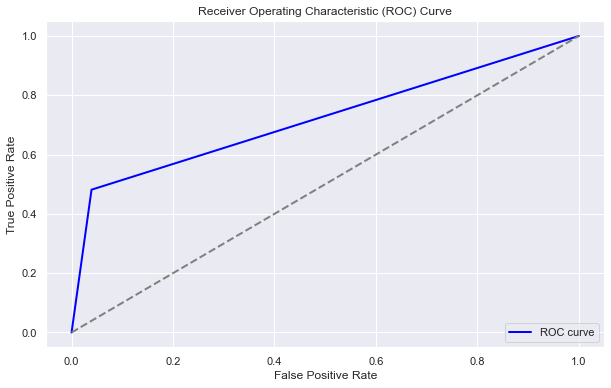

In [56]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [110]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1200,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.05,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3
                              )

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9259183545100013

In [111]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9196

* Confusion Matrix: 
[[28176  1561]
 [  996  1064]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.41      0.52      0.45      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.73      0.71     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7320


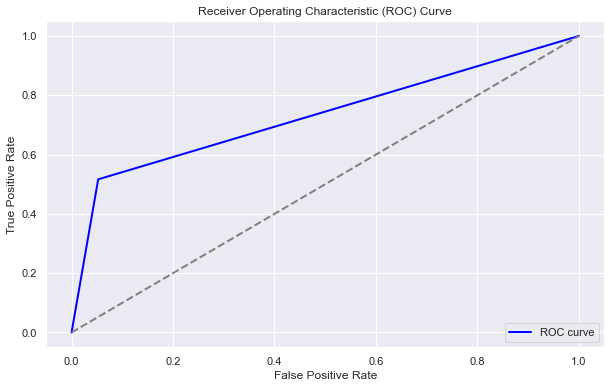

In [112]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [113]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5.5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9306044785507611

In [114]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9185

* Confusion Matrix: 
[[28123  1614]
 [  977  1083]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.40      0.53      0.46      2060

    accuracy                           0.92     31797
   macro avg       0.68      0.74      0.71     31797
weighted avg       0.93      0.92      0.92     31797



In [97]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9404170335891308

In [98]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.933

* Confusion Matrix: 
[[28709  1028]
 [ 1101   959]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29737
           1       0.48      0.47      0.47      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.72      0.72     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7155


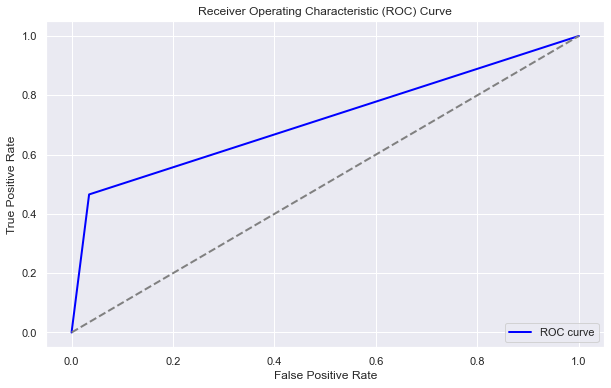

In [99]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [121]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.934748081519688

In [122]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9229

* Confusion Matrix: 
[[28294  1443]
 [ 1008  1052]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.42      0.51      0.46      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.73      0.71     31797
weighted avg       0.93      0.92      0.93     31797



ROC AUC score: 0.7311


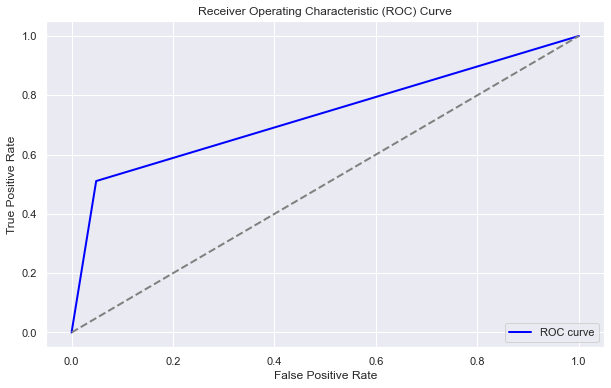

In [123]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [125]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1000,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=sum(y_train == 0) / sum(y_train == 1),
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.8497688388476538

In [126]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8355

* Confusion Matrix: 
[[25136  4601]
 [  631  1429]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     29737
           1       0.24      0.69      0.35      2060

    accuracy                           0.84     31797
   macro avg       0.61      0.77      0.63     31797
weighted avg       0.93      0.84      0.87     31797



ROC AUC score: 0.7695


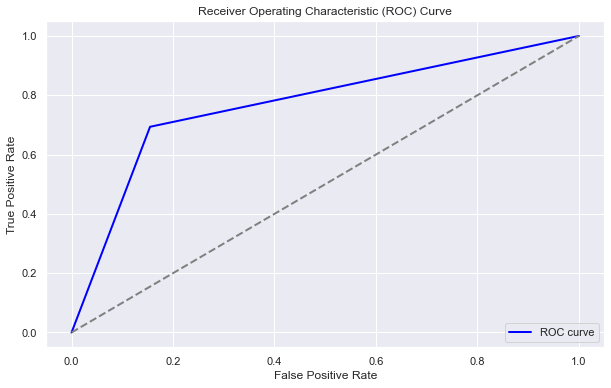

In [127]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [203]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=3)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9240234620707007

In [204]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9199

* Confusion Matrix: 
[[28178  1559]
 [  988  1072]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.41      0.52      0.46      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.73      0.71     31797
weighted avg       0.93      0.92      0.92     31797



ROC AUC score: 0.7330


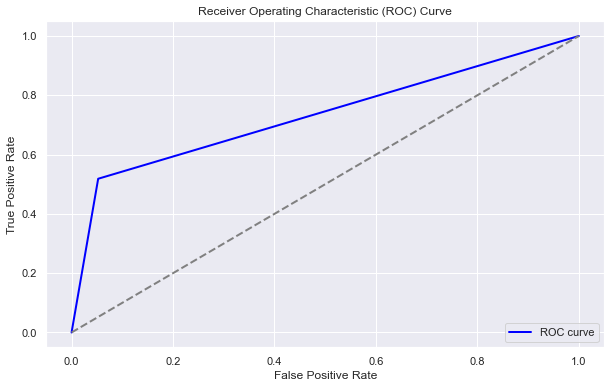

In [130]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [131]:
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()

gauss_model = gauss.fit(X_train, y_train)
gauss_model.score(X_train, y_train)

0.7920414517549377

In [132]:
fc.eval_clf_testset(gauss_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7901

* Confusion Matrix: 
[[23888  5849]
 [  826  1234]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.80      0.88     29737
           1       0.17      0.60      0.27      2060

    accuracy                           0.79     31797
   macro avg       0.57      0.70      0.57     31797
weighted avg       0.92      0.79      0.84     31797



In [133]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state = 42)

tree_clf = tree.fit(X_train, y_train)
tree_clf.score(X_train, y_train)

1.0

In [134]:
fc.eval_clf_testset(tree_clf, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9015

* Confusion Matrix: 
[[28021  1716]
 [ 1415   645]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     29737
           1       0.27      0.31      0.29      2060

    accuracy                           0.90     31797
   macro avg       0.61      0.63      0.62     31797
weighted avg       0.91      0.90      0.90     31797



In [135]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})
logit_model = logit.fit(X_train, y_train)

logit_model.score(X_train, y_train)

0.7591756824757832

In [136]:
fc.eval_clf_testset(logit_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7596

* Confusion Matrix: 
[[22662  7075]
 [  568  1492]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     29737
           1       0.17      0.72      0.28      2060

    accuracy                           0.76     31797
   macro avg       0.57      0.74      0.57     31797
weighted avg       0.92      0.76      0.82     31797



In [139]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.7745628380928419

In [140]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.7779

* Confusion Matrix: 
[[23261  6476]
 [  585  1475]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     29737
           1       0.19      0.72      0.29      2060

    accuracy                           0.78     31797
   macro avg       0.58      0.75      0.58     31797
weighted avg       0.92      0.78      0.83     31797



In [141]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.924385142785256

In [142]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9274

* Confusion Matrix: 
[[28681  1056]
 [ 1254   806]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.43      0.39      0.41      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.68      0.69     31797
weighted avg       0.92      0.93      0.93     31797



In [144]:
logit = LogisticRegression(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
logit_model = logit.fit(X_train_norm, y_train)

logit_model.score(X_train_norm, y_train)

0.8546593911183796

In [145]:
fc.eval_clf_testset(logit_model, X_test_norm, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.856

* Confusion Matrix: 
[[25982  3755]
 [  823  1237]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.87      0.92     29737
           1       0.25      0.60      0.35      2060

    accuracy                           0.86     31797
   macro avg       0.61      0.74      0.63     31797
weighted avg       0.92      0.86      0.88     31797



In [146]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw[0], 1: sw[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [147]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.908

* Confusion Matrix: 
[[28266  1471]
 [ 1455   605]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.29      0.29      0.29      2060

    accuracy                           0.91     31797
   macro avg       0.62      0.62      0.62     31797
weighted avg       0.91      0.91      0.91     31797



In [148]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_zen[0], 1: sw_zen[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [149]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9065

* Confusion Matrix: 
[[28246  1491]
 [ 1483   577]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.28      0.28      0.28      2060

    accuracy                           0.91     31797
   macro avg       0.61      0.61      0.61     31797
weighted avg       0.91      0.91      0.91     31797



In [150]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_isns[0], 1: sw_isns[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [151]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9055

* Confusion Matrix: 
[[28156  1581]
 [ 1423   637]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.29      0.31      0.30      2060

    accuracy                           0.91     31797
   macro avg       0.62      0.63      0.62     31797
weighted avg       0.91      0.91      0.91     31797



In [152]:
tree = DecisionTreeClassifier(random_state = 42, class_weight = {0: sw_eff[0], 1: sw_eff[1]})

tree_model = tree.fit(X_train, y_train)
tree_model.score(X_train, y_train)

1.0

In [153]:
fc.eval_clf_testset(tree_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9076

* Confusion Matrix: 
[[28247  1490]
 [ 1449   611]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     29737
           1       0.29      0.30      0.29      2060

    accuracy                           0.91     31797
   macro avg       0.62      0.62      0.62     31797
weighted avg       0.91      0.91      0.91     31797



In [154]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42, n_estimators = 100)
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999842747515411

In [155]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9458

* Confusion Matrix: 
[[29639    98]
 [ 1625   435]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.82      0.21      0.34      2060

    accuracy                           0.95     31797
   macro avg       0.88      0.60      0.65     31797
weighted avg       0.94      0.95      0.93     31797



In [156]:
forest = RandomForestClassifier(random_state = 42, n_estimators = 100, class_weight = {0: sw_eff[0], 1: sw_eff[1]})
forest_model = forest.fit(X_train, y_train)

forest_model.score(X_train, y_train)

0.9999685495030821

In [157]:
fc.eval_clf_testset(forest_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.945

* Confusion Matrix: 
[[29655    82]
 [ 1667   393]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     29737
           1       0.83      0.19      0.31      2060

    accuracy                           0.94     31797
   macro avg       0.89      0.59      0.64     31797
weighted avg       0.94      0.94      0.93     31797



In [168]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9394106176877595

In [169]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9332

* Confusion Matrix: 
[[28704  1033]
 [ 1092   968]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29737
           1       0.48      0.47      0.48      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.72      0.72     31797
weighted avg       0.93      0.93      0.93     31797



ROC AUC score: 0.7176


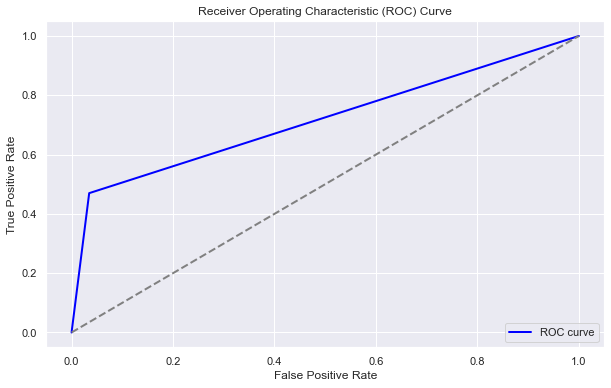

In [170]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))

In [171]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [172]:
class_weights_dict = dict(enumerate(class_weights))

In [173]:
class_weights_dict

{0: 0.5346379160753559, 1: 7.717524271844661}

In [174]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 900,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               class_weight = class_weights_dict,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.846883255755441

In [175]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.8326

* Confusion Matrix: 
[[25044  4693]
 [  631  1429]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.84      0.90     29737
           1       0.23      0.69      0.35      2060

    accuracy                           0.83     31797
   macro avg       0.60      0.77      0.63     31797
weighted avg       0.93      0.83      0.87     31797



In [176]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_model = xgb_clf.fit(X_train, y_train)

xgb_model.score(X_train, y_train)

0.9581315259781105

In [177]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9461

* Confusion Matrix: 
[[29525   212]
 [ 1501   559]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     29737
           1       0.73      0.27      0.39      2060

    accuracy                           0.95     31797
   macro avg       0.84      0.63      0.68     31797
weighted avg       0.94      0.95      0.93     31797



In [182]:
xgb_clf = xgb.XGBClassifier(random_state = 42, n_estimators = 1000,
                            colsample_bytree=0.5646751146007976,
                            learning_rate=0.1419865761603358,
                            max_bin=824,
                            scale_pos_weight=5,
                            min_child_weight=1,
                            reg_alpha=1.6259583347890365e-07,
                            reg_lambda=2.110691851528507e-08,
                            subsample=0.879020578464637,
                            objective='binary:logistic',
                            max_depth=4,
                            n_jobs=-1,
                            verbosity=0)

xgb_model = xgb_clf.fit(X_train, y_train)
xgb_model.score(X_train, y_train)

0.9550886904013084

In [183]:
fc.eval_clf_testset(xgb_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9272

* Confusion Matrix: 
[[28511  1226]
 [ 1089   971]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     29737
           1       0.44      0.47      0.46      2060

    accuracy                           0.93     31797
   macro avg       0.70      0.72      0.71     31797
weighted avg       0.93      0.93      0.93     31797



In [184]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, sampling_strategy='minority')

X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [185]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 1500,
                               scale_pos_weight=5)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.991584274952919

In [186]:
fc.eval_clf_testset(lgbm_model, X_train, y_train)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9843

* Confusion Matrix: 
[[117532   1412]
 [   587   7653]]

* Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    118944
           1       0.84      0.93      0.88      8240

    accuracy                           0.98    127184
   macro avg       0.92      0.96      0.94    127184
weighted avg       0.99      0.98      0.98    127184



In [187]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9319

* Confusion Matrix: 
[[28751   986]
 [ 1179   881]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     29737
           1       0.47      0.43      0.45      2060

    accuracy                           0.93     31797
   macro avg       0.72      0.70      0.71     31797
weighted avg       0.93      0.93      0.93     31797



In [188]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.02,
                               reg_alpha=0.02,
                               scale_pos_weight=5,
                               min_child_weight=0.05,
                               learning_rate=0.055,
                               subsample=0.85,
                               colsample_bytree=0.85,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train_rs, y_train_rs)

lgbm_model.score(X_train_rs, y_train_rs)

0.9505229351627656

In [189]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9023

* Confusion Matrix: 
[[27552  2185]
 [  923  1137]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     29737
           1       0.34      0.55      0.42      2060

    accuracy                           0.90     31797
   macro avg       0.65      0.74      0.68     31797
weighted avg       0.93      0.90      0.91     31797



In [208]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
param_grid = {'boosting_type': ['gbdt', 'dart'],
              'n_estimators': [500, 600, 800, 900, 1000, 1200],
              'num_leaves': [7, 10, 20, 30],
              'max_depth': [2, 3, 4, 5, 6, -1],
              'learning_rate': np.linspace(0.01, 0.09, 15),
              'subsample': np.linspace(0, 1, 15),
              'colsample_bytree': np.linspace(0, 1, 15),
              'reg_alpha': np.linspace(0, 0.1, 15),
              'reg_lambda': np.linspace(0, 0.1, 15),
              'min_child_weight': [0, 5, 10, 15, 20, 25],
              'class_weight': ['balanced', None]
}

lgbm_clf = lgbm.LGBMClassifier()

random_search = RandomizedSearchCV(lgbm_clf, param_grid, n_iter=10, cv=5, scoring='roc_auc', random_state=42)
t0 = time.time()
random_search.fit(X_train, y_train)
t1 = time.time()

print('Random Search took: {:.2f} minutes'.format((t1-t0)/60))

Random Search took: 21.49 minutes


In [210]:
print("RandomizedSearchCV Best Params:", random_search.best_params_)

RandomizedSearchCV Best Params: {'subsample': 0.21428571428571427, 'reg_lambda': 0.1, 'reg_alpha': 0.02142857142857143, 'num_leaves': 20, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.027142857142857142, 'colsample_bytree': 0.7857142857142857, 'class_weight': None, 'boosting_type': 'gbdt'}


In [211]:
print("RandomizedSearchCV Best Score:", random_search.best_score_)

RandomizedSearchCV Best Score: 0.8577410547679367


In [212]:
best_model = random_search.best_estimator_
best_model

LGBMClassifier(colsample_bytree=0.7857142857142857,
               learning_rate=0.027142857142857142, max_depth=6,
               min_child_weight=10, n_estimators=500, num_leaves=20,
               reg_alpha=0.02142857142857143, reg_lambda=0.1,
               subsample=0.21428571428571427)

In [226]:
lgbm_clf = lgbm.LGBMClassifier(random_state = 42, n_estimators = 800,
                               reg_lambda=0.1,
                               reg_alpha=0.02142857142857143,
#                                class_weight = {0: sw_isns[0], 1: sw_isns[1]},
                               scale_pos_weight=5,
                               min_child_weight=10,
                               learning_rate=0.027142857142857142,
                               subsample=0.21428571428571427,
                               colsample_bytree=0.7857142857142857,
                               num_leaves=20,
                               max_depth=4)

lgbm_model = lgbm_clf.fit(X_train, y_train)

lgbm_model.score(X_train, y_train)

0.9255488111712165

In [227]:
fc.eval_clf_testset(lgbm_model, X_test, y_test)

----- EVALUATION MODEL PERFORMANCE ON TESTING SET -----
* Testing Accuracy score: 0.9213

* Confusion Matrix: 
[[28234  1503]
 [ 1001  1059]]

* Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     29737
           1       0.41      0.51      0.46      2060

    accuracy                           0.92     31797
   macro avg       0.69      0.73      0.71     31797
weighted avg       0.93      0.92      0.93     31797



ROC AUC score: 0.7318


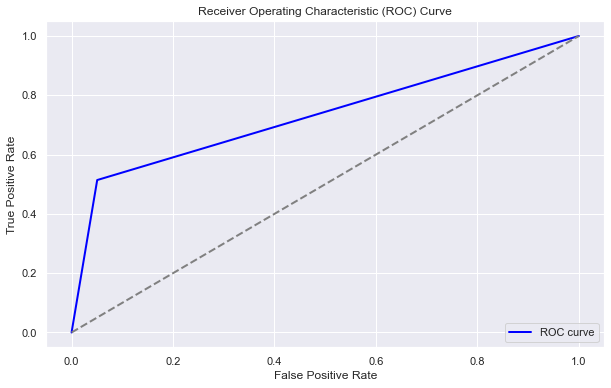

In [228]:
fc.plot_roc_curve(y_test, lgbm_model.predict(X_test))